# Lesson 6: Essay Writer

In [ ]:
from dotenv import load_dotenv

_ = load_dotenv()

In [33]:
import os
from dotenv import find_dotenv

_ = load_dotenv(find_dotenv())
# Get the environment variable
api_key = os.getenv("OPENAI_API_KEY")
#print(api_key)
tavily = os.getenv("TAVILY_API_KEY")

In [34]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from langgraph.checkpoint.memory import MemorySaver

memory = SqliteSaver.from_conn_string(":memory:")

In [4]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [5]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [6]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

In [7]:
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

------

{content}"""

In [8]:
REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [9]:
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""


In [10]:
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""


In [11]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [12]:
from tavily import TavilyClient
import os
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [13]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [14]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [15]:
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }


In [16]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [17]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [18]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [19]:
builder = StateGraph(AgentState)

In [20]:
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [21]:
builder.set_entry_point("planner")

In [22]:
builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END, "reflect": "reflect"}
)


In [23]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [24]:
graph = builder.compile(checkpointer=MemorySaver())

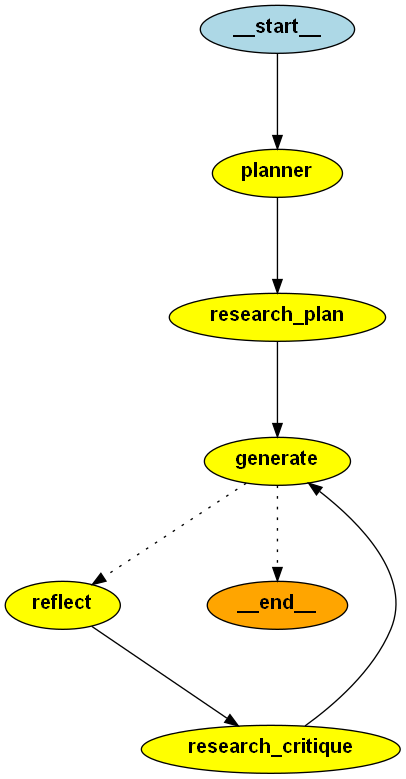

In [25]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [26]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'task': "what is the difference between langchain and langsmith",
    "max_revisions": 2,
    "revision_number": 1,
}, thread):
    print(s)


{'planner': {'plan': '**Essay Outline: The Difference Between LangChain and LangSmith**\n\n**I. Introduction**\n   A. Definition of LangChain and LangSmith\n      1. Brief overview of what each tool is designed for\n      2. Importance of understanding the differences in the context of AI and language processing\n   B. Purpose of the essay\n      1. To compare and contrast LangChain and LangSmith\n      2. To provide insights into their respective use cases and functionalities\n\n**II. Overview of LangChain**\n   A. Description of LangChain\n      1. Purpose and primary functions\n      2. Key features and capabilities\n   B. Use cases of LangChain\n      1. Applications in natural language processing (NLP)\n      2. Examples of industries or scenarios where LangChain is utilized\n\n**III. Overview of LangSmith**\n   A. Description of LangSmith\n      1. Purpose and primary functions\n      2. Key features and capabilities\n   B. Use cases of LangSmith\n      1. Applications in AI deve

## Essay Writer Interface

### Helper.py

In [27]:
import warnings
warnings.filterwarnings("ignore")

from helper import ewriter, writer_gui

In [29]:
MultiAgent = ewriter()
app = writer_gui(MultiAgent.graph)
app.launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "C:\Users\SHREYAS\venv-langgraph\lib\site-packages\gradio\queueing.py", line 528, in process_events
    response = await route_utils.call_process_api(
  File "C:\Users\SHREYAS\venv-langgraph\lib\site-packages\gradio\route_utils.py", line 270, in call_process_api
    output = await app.get_blocks().process_api(
  File "C:\Users\SHREYAS\venv-langgraph\lib\site-packages\gradio\blocks.py", line 1908, in process_api
    result = await self.call_function(
  File "C:\Users\SHREYAS\venv-langgraph\lib\site-packages\gradio\blocks.py", line 1485, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "C:\Users\SHREYAS\venv-langgraph\lib\site-packages\anyio\to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
  File "C:\Users\SHREYAS\venv-langgraph\lib\site-packages\anyio\_backends\_asyncio.py", line 2177, in run_sync_in_worker_thread
    return await future
  File "C:\Users\SHREYAS\venv-lang